#Text Classification - Lexicon-based Auto Labelling - LSTM

## Tahapan :
1. Import dan Install Library
2. Data Information
3. Auto Labelling
4. Preprocessing
5. Weighting / Sentence Conversion / Word Embedding

##1. Import and Install Library

In [ ]:
import pandas as pd
import string
import numpy as np
from urllib.request import urlopen

from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# !pip install textattack
# from textattack.augmentation import EasyDataAugmenter
# eda_aug = EasyDataAugmenter()

#preprocessing
##casefolding
import re 
##tokenize, stopword, stemming
import nltk
import gensim
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer

#vader sentiment
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#textblog
# !pip install textblob
# import textblob

#afinn
!pip install afinn
from afinn import Afinn
afn = Afinn(emoticons = True)

#sentiwordnet
import ssl
nltk.download('sentiwordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

import time
import os

#vectorize and data split
##tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
##data split
from sklearn.model_selection import train_test_split

#word embedding & LSTM
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

#classsify 
##evaulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#export model
import pickle

# #validate
# ##wordcloud
# from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 

#k-fold cross validation
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##2. Data Information

###Load Dataset

In [ ]:
url = 'https://drive.google.com/file/d/165stcwTpdrkQPzYNOrickao7s5_No6q1/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]


df = pd.read_csv(path)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


###Get Required Column

In [ ]:
data = df[['text', 'airline_sentiment','airline_sentiment_confidence']].copy()
data = data.rename(columns={'airline_sentiment':'label'})
data['text'] = data['text'].apply(lambda x : x.encode('ISO-8859-1', 'ignore').decode("utf-8", 'ignore'))

username_pattern = re.compile(r"@(\w+)")
data['text'] = data['text'].apply(lambda x : re.sub(username_pattern, '', x))

data.head()

,text,label,airline_sentiment_confidence
0,What said.,neutral,1.0000
1,plus you've added commercials to the experien...,positive,0.3486
2,I didn't today... Must mean I need to take an...,neutral,0.6837
3,"it's really aggressive to blast obnoxious ""en...",negative,1.0000
4,and it's a really big bad thing about it,negative,1.0000


###General Information

In [ ]:
data.shape

(14640, 3)

In [ ]:
data.groupby('label')['label'].count()

label
negative    9178
neutral     3099
positive    2363
Name: label, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          14640 non-null  object 
 1   label                         14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
dtypes: float64(1), object(2)
memory usage: 343.2+ KB


In [ ]:
data.describe()

,airline_sentiment_confidence
count,14640.000000
mean,0.900169
std,0.162830
min,0.335000
25%,0.692300
50%,1.000000
75%,1.000000
max,1.000000


### Check Missing Values

In [ ]:
data.isnull().sum()

text                            0
label                           0
airline_sentiment_confidence    0
dtype: int64

##3. Automatic Labelling

### VADER

####Create Sentiment Score Function

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def vader_score(sentence):
    sntmnt = analyzer.polarity_scores(sentence)['compound']
    return sntmnt

def vader_label(score):
    if (score >= 0.05):
        return 'positive'
    elif ((score > -0.05) & (score < 0.05)):
        return 'neutral'
    elif (score <= -0.05):
        return 'negative'

####Calculate Sentiment Score & Create Label

In [ ]:
# start = time.time()

# eng_snt_score =  []

# for text in data.text.to_list():
#     snts_score = calculate_sentiment_scores(text)
#     eng_snt_score.append(snts_score)

data['vader_score'] = data.text.apply(vader_score)
data['vader_label'] = data.vader_score.apply(vader_label)
    
# end = time.time()

# # total time taken
# print(f"Runtime of the program is {(end - start)/60} minutes or {(end - start)} seconds")

In [ ]:
data.head()

,text,label,airline_sentiment_confidence,vader_score,vader_label
0,What said.,neutral,1.0000,0.0000,neutral
1,plus you've added commercials to the experien...,positive,0.3486,0.0000,neutral
2,I didn't today... Must mean I need to take an...,neutral,0.6837,0.0000,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative,1.0000,-0.2716,negative
4,and it's a really big bad thing about it,negative,1.0000,-0.5829,negative


In [ ]:
data['vader_score'].max()

0.981

### AFINN-111

####Create Afinn-111 Classification Function

In [ ]:
# def make_sentences(text):
#     sentences = [sent for sent in split_single(text)]
#     return sentences
def afinn_score(sentence):
    score = afn.score(sentence)
    return score

def afinn_label(score):
    if (score > 0):
        return 'positive'
    elif (score < 0):
        return 'negative'
    else:
        return 'neutral'

# def get_predict_result(sentences):
#     """ Call predict on every sentence of a text """
#     flair_confidence = []
    
#     for i in range(0, len(sentences)): 
#         flair_confidence.append(flair_predict(sentences[i]))
#     return flair_confidence

# def flair_predict_confidence(sentence):
#     text = Sentence(sentence)
#     classifier.predict(text)
#     return text.labels[0].to_dict()['confidence']

In [ ]:
print(afinn_score('omg'))
print(afinn_score('finally'))
print(afinn_label(0))

0.0
0.0
neutral


####Calculate Sentiment Score & Create Label

In [ ]:
# data['sentences'] = data.text.apply(make_sentences)
data['afinn_score'] = data.text.apply(afinn_score)
data['afinn_label'] = data.afinn_score.apply(afinn_label)

In [ ]:
data.head()

,text,label,airline_sentiment_confidence,vader_score,vader_label,afinn_score,afinn_label
0,What said.,neutral,1.0000,0.0000,neutral,0.0,neutral
1,plus you've added commercials to the experien...,positive,0.3486,0.0000,neutral,0.0,neutral
2,I didn't today... Must mean I need to take an...,neutral,0.6837,0.0000,neutral,0.0,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative,1.0000,-0.2716,negative,-5.0,negative
4,and it's a really big bad thing about it,negative,1.0000,-0.5829,negative,-2.0,negative


###SentiWordNet

####Create SWN Function

In [ ]:
#SWN postagging
pos=neg=obj=count=0

postagging = []

for text in data['text']:
    list = nltk.word_tokenize(text)
    postagging.append(nltk.pos_tag(list))

data['pos_tags'] = postagging

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
lemmatizer = WordNetLemmatizer()
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
def swn_label(score):
    if score>= 0.05:
        return 'positive'
    elif score<= -0.05:
        return 'negative'
    else:
        return 'neutral'

####Calculate SWN Score & Create Label

In [ ]:
swn_score = []

for pos_val in data['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    swn_score.append(pos - neg)
    pos=neg=0   

data = data.drop('pos_tags', 1)
    
data['swn_score'] = swn_score
data['swn_label'] = data.swn_score.apply(swn_label)

In [ ]:
data.tail(100)

,text,label,airline_sentiment_confidence,vader_score,vader_label,afinn_score,afinn_label,swn_score,swn_label
14540,tried ringing but told me to try again Late F...,negative,1.0000,0.0000,neutral,0.0,neutral,0.625,positive
14541,You guys did an amazing job today! Know its h...,positive,1.0000,0.7835,positive,2.0,positive,-0.875,negative
14542,. cover a rental car or refund our ticket? - I...,negative,1.0000,0.1759,positive,-2.0,negative,0.250,positive
14543,should reconsider #usairways acquisition. Fli...,negative,1.0000,-0.5562,negative,0.0,neutral,0.000,neutral
14544,You neglected to mention the $200 fee per t...,negative,1.0000,-0.5267,negative,-2.0,negative,-0.125,negative
...,...,...,...,...,...,...,...,...,...
14635,thank you we got on a different flight to Chi...,positive,0.3487,0.3612,positive,2.0,positive,0.625,positive
14636,leaving over 20 minutes Late Flight. No warni...,negative,1.0000,-0.4043,negative,-7.0,negative,-1.125,negative
14637,Please bring American Airlines to #BlackBerry10,neutral,1.0000,0.3182,positive,1.0,positive,0.000,neutral
14638,"you have my money, you change my flight, and ...",negative,1.0000,0.5027,positive,2.0,positive,-0.125,negative


###Bing Liu 

####Load Bing Liu Dictionary

In [ ]:
#Load Dictionary
liu_url_neg = 'https://drive.google.com/file/d/1oJjlPwAp5VMt4kSXiJ3a4lM11JPw2pph/view?usp=sharing'
liu_path_neg = 'https://drive.google.com/uc?export=download&id='+liu_url_neg.split('/')[-2]

liu_url_pos = 'https://drive.google.com/file/d/10PRSFz1NvtUILZ07yu8LpDY-ju-kv3D6/view?usp=sharing'
liu_path_pos = 'https://drive.google.com/uc?export=download&id='+liu_url_pos.split('/')[-2]

liu_df_temp = pd.read_csv(liu_path_neg, header=None)
liu_df_temp['1'] = pd.read_csv(liu_path_pos, header=None)

liu_dict_neg = liu_df_temp[0].to_list()
liu_dict_pos = liu_df_temp['1'].to_list()

print(liu_dict_pos)
print(liu_dict_neg)

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'agility', 'agreeable', 'ag

In [ ]:
liu_df_temp.describe()

,0,1
count,4783,2006
unique,4783,2006
top,2-faced,a+
freq,1,1


In [ ]:
len(liu_dict_neg)

4783

In [ ]:
print(4783+2006)

6789


####Create Bing Liu Function

In [ ]:
def liu_label(sentence):
    tokens = nltk.word_tokenize(sentence)
    neg_count = 0
    pos_count = 0
    for neg in liu_dict_neg:
        if (neg in tokens):
            neg_count = neg_count +1
    for pos in liu_dict_pos:
        if (pos in tokens):
            pos_count = pos_count +1
    if pos_count > neg_count :
        return 'positive'
    elif neg_count > pos_count :
        return 'negative'
    else :
        return 'neutral'

####Calculate Sentiment Score and Create Label

In [ ]:
data['liu_label'] = data.text.apply(liu_label)

In [ ]:
data.head()

,text,label,airline_sentiment_confidence,vader_score,vader_label,afinn_score,afinn_label,swn_score,swn_label,liu_score,liu_label
0,What said.,neutral,1.0000,0.0000,neutral,0.0,neutral,0.000,neutral,0,neutral
1,plus you've added commercials to the experien...,positive,0.3486,0.0000,neutral,0.0,neutral,0.000,neutral,1,positive
2,I didn't today... Must mean I need to take an...,neutral,0.6837,0.0000,neutral,0.0,neutral,0.500,positive,0,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative,1.0000,-0.2716,negative,-5.0,negative,0.125,positive,2,positive
4,and it's a really big bad thing about it,negative,1.0000,-0.5829,negative,-2.0,negative,0.125,positive,1,positive


###Show Data

In [ ]:
data[['text', 'airline_sentiment_confidence', 'vader_score', 'afinn_score', 'swn_score', 'liu_score']].head()

,text,airline_sentiment_confidence,vader_score,afinn_score,swn_score,liu_score
0,What said.,1.0000,0.0000,0.0,0.000,0
1,plus you've added commercials to the experien...,0.3486,0.0000,0.0,0.000,1
2,I didn't today... Must mean I need to take an...,0.6837,0.0000,0.0,0.500,0
3,"it's really aggressive to blast obnoxious ""en...",1.0000,-0.2716,-5.0,0.125,2
4,and it's a really big bad thing about it,1.0000,-0.5829,-2.0,0.125,1


In [ ]:
data[['text', 'label', 'vader_label', 'afinn_label', 'swn_label', 'liu_label']].head()

,text,label,vader_label,afinn_label,swn_label,liu_label
0,What said.,neutral,neutral,neutral,neutral,neutral
1,plus you've added commercials to the experien...,positive,neutral,neutral,neutral,positive
2,I didn't today... Must mean I need to take an...,neutral,neutral,neutral,positive,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative,negative,negative,positive,positive
4,and it's a really big bad thing about it,negative,negative,negative,positive,positive


In [ ]:
kalimat = 'guys need serious training customer service many better options put way guys handle ur mistakes'

list_token_kalimat_tes = nltk.word_tokenize(kalimat)

for kata in list_token_kalimat_tes:
    print(liu_label(kata))

print('skor akhir : ',liu_label(kalimat))

# print(vader_score('omg'))
# print(vader_score('finally'))
# print(vader_label(0))

neutral
neutral
neutral
neutral
neutral
neutral
neutral
positive
neutral
neutral
neutral
neutral
neutral
neutral
negative
skor akhir :  neutral


In [ ]:
data.loc[(data['label']!=data['vader_label']) & (data['label']!=data['afinn_label']) & (data['label']!=data['swn_label'])& (data['label']!=data['liu_label'])]

,text,label,airline_sentiment_confidence,vader_score,vader_label,afinn_score,afinn_label,swn_score,swn_label,liu_score,liu_label
10,know suicide second leading cause death among ...,neutral,0.6769,-0.8555,negative,-2.0,negative,0.125,positive,1,positive
17,flew nyc sfo last week couldnt fully sit seat ...,negative,1.0000,0.5754,positive,2.0,positive,0.500,positive,0,neutral
18,flying,positive,1.0000,0.0000,neutral,0.0,neutral,0.000,neutral,0,neutral
24,guys messed seating reserved seating friends g...,negative,1.0000,0.6486,positive,0.0,neutral,0.500,positive,0,neutral
27,miss dont worry well together soon,neutral,0.6854,0.2037,positive,-5.0,negative,-0.125,negative,2,positive
...,...,...,...,...,...,...,...,...,...,...,...
14620,wait 2+ hrs cs call back flt cld protection am...,negative,1.0000,0.0000,neutral,0.0,neutral,0.000,neutral,1,positive
14624,call chairman call emerald today call former c...,negative,1.0000,0.0000,neutral,0.0,neutral,0.000,neutral,0,neutral
14629,change flight phone system keeps telling repre...,negative,1.0000,0.0000,neutral,0.0,neutral,0.375,positive,0,neutral
14632,george doesnt look good please follow link sta...,neutral,0.6760,-0.5216,negative,4.0,positive,0.750,positive,-2,negative


### Lexicon Result

In [ ]:
data.head()

,text,label,airline_sentiment_confidence,vader_score,vader_label,afinn_score,afinn_label,swn_score,swn_label,liu_score,liu_label
0,What said.,neutral,1.0000,0.0000,neutral,0.0,neutral,0.000,neutral,0,neutral
1,plus you've added commercials to the experien...,positive,0.3486,0.0000,neutral,0.0,neutral,0.000,neutral,1,positive
2,I didn't today... Must mean I need to take an...,neutral,0.6837,0.0000,neutral,0.0,neutral,0.500,positive,0,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative,1.0000,-0.2716,negative,-5.0,negative,0.125,positive,2,positive
4,and it's a really big bad thing about it,negative,1.0000,-0.5829,negative,-2.0,negative,0.125,positive,1,positive


In [ ]:
data_count = data.groupby(['label']).size().to_frame()
data_count['vader'] = data.groupby(['vader_label']).size().to_frame()
# data_count['textblob'] = data.groupby(['textblob_label']).size().to_frame()
data_count['afinn'] = data.groupby(['afinn_label']).size().to_frame()
data_count['swn'] = data.groupby(['swn_label']).size().to_frame()
data_count['liu'] = data.groupby(['liu_label']).size().to_frame()

data_count.head().reset_index().rename(columns={0: 'manual'})

,label,manual,vader,afinn,swn,liu
0,negative,9178,5175,4973,5210,3355
1,neutral,3099,3302,4074,4263,7211
2,positive,2363,6163,5593,5167,4074


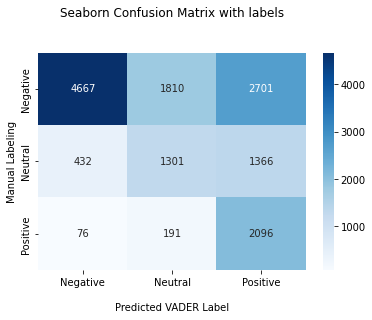

In [ ]:
# import seaborn as sns

# cm = confusion_matrix(data['label'], data['vader_label'])
# f = sns.heatmap(cm, annot=True)

# from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(data['label'], data['vader_label'])

# print(cf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted VADER Label')
ax.set_ylabel('Manual Labeling');

# ## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
vader_accuracy = accuracy_score(data['vader_label'],data['label'])
print('VADER Accuracy : ', vader_accuracy)
print(classification_report(data['label'],data['vader_label']))

VADER Accuracy :  0.5508196721311476
              precision    recall  f1-score   support

    negative       0.90      0.51      0.65      9178
     neutral       0.39      0.42      0.41      3099
    positive       0.34      0.89      0.49      2363

    accuracy                           0.55     14640
   macro avg       0.55      0.61      0.52     14640
weighted avg       0.70      0.55      0.57     14640



In [ ]:
# textblob_accuracy = accuracy_score(data['label'],data['textblob_label'])
# print('TextBlob Accuracy : ', textblob_accuracy)
# print(classification_report(data['label'],data['textblob_label']))

In [ ]:
afinn_accuracy = accuracy_score(data['label'],data['afinn_label'])
print('AFINN111 Accuracy : ', afinn_accuracy)
print(classification_report(data['label'],data['afinn_label']))

AFINN111 Accuracy :  0.5433060109289618
              precision    recall  f1-score   support

    negative       0.90      0.49      0.63      9178
     neutral       0.37      0.49      0.42      3099
    positive       0.36      0.84      0.50      2363

    accuracy                           0.54     14640
   macro avg       0.54      0.60      0.52     14640
weighted avg       0.70      0.54      0.56     14640



In [ ]:
swn_accuracy = accuracy_score(data['label'],data['swn_label'])
print('SWN Accuracy : ', swn_accuracy)
print(classification_report(data['label'],data['swn_label']))

SWN Accuracy :  0.47452185792349727
              precision    recall  f1-score   support

    negative       0.79      0.45      0.57      9178
     neutral       0.33      0.45      0.38      3099
    positive       0.27      0.60      0.38      2363

    accuracy                           0.47     14640
   macro avg       0.47      0.50      0.44     14640
weighted avg       0.61      0.47      0.50     14640



In [ ]:
liu_accuracy = accuracy_score(data['label'],data['liu_label'])
print('Liu Accuracy : ', liu_accuracy)
print(classification_report(data['label'],data['liu_label']))

Liu Accuracy :  0.25594262295081965
              precision    recall  f1-score   support

    negative       0.43      0.16      0.23      9178
     neutral       0.30      0.70      0.42      3099
    positive       0.03      0.06      0.04      2363

    accuracy                           0.26     14640
   macro avg       0.26      0.30      0.23     14640
weighted avg       0.34      0.26      0.24     14640



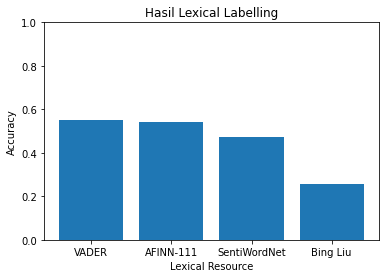

In [ ]:
import matplotlib.pyplot as plt
bar_text = ['VADER', 'AFINN-111', 'SentiWordNet', 'Bing Liu']
bar_value = [vader_accuracy, afinn_accuracy, swn_accuracy, liu_accuracy]
plt.bar(bar_text, bar_value)
plt.title('Hasil Lexical Labelling')
plt.xlabel('Lexical Resource')
plt.ylabel('Accuracy')
plt.axis([None, None, 0, 1])
plt.show()

###Export CSV

In [ ]:
data.to_csv('labelled-fixed.csv', index=False)

##4. Preprocessing

In [ ]:
data = pd.read_csv('labelled-fixed.csv')

In [ ]:
#2nd method preprocessing

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

data['text'] = data['text'].apply(clean_text)
data.head()

,text,label,airline_sentiment_confidence,vader_score,vader_label,afinn_score,afinn_label,swn_score,swn_label,liu_score,liu_label
0,said,neutral,1.0000,0.0000,neutral,0.0,neutral,0.000,neutral,0,neutral
1,plus youve added commercials eperience tacky,positive,0.3486,0.0000,neutral,0.0,neutral,0.000,neutral,1,positive
2,didnt today must mean need take another trip,neutral,0.6837,0.0000,neutral,0.0,neutral,0.500,positive,0,neutral
3,really aggressive blast obnoious entertainment...,negative,1.0000,-0.2716,negative,-5.0,negative,0.125,positive,2,positive
4,really big bad thing,negative,1.0000,-0.5829,negative,-2.0,negative,0.125,positive,1,positive


In [ ]:
data.loc[3]

text                            really aggressive blast obnoious entertainment...
label                                                                    negative
airline_sentiment_confidence                                                  1.0
vader_score                                                               -0.2716
vader_label                                                              negative
afinn_score                                                                  -5.0
afinn_label                                                              negative
swn_score                                                                   0.125
swn_label                                                                positive
liu_score                                                                       2
liu_label                                                                positive
Name: 3, dtype: object

In [ ]:
data.to_csv('labelled-preprocessed.csv', index=False)

##5. Embedding & Modeling

###Select and Split Data

In [ ]:
data_clean = data[['text','label','vader_label','afinn_label','swn_label','liu_label']].copy()

In [ ]:
data_clean.head()

,text,label,vader_label,afinn_label,swn_label,liu_label
0,said,neutral,neutral,neutral,neutral,neutral
1,plus youve added commercials eperience tacky,positive,neutral,neutral,neutral,positive
2,didnt today must mean need take another trip,neutral,neutral,neutral,positive,neutral
3,really aggressive blast obnoious entertainment...,negative,negative,negative,positive,positive
4,really big bad thing,negative,negative,negative,positive,positive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(data_clean, test_size=0.2)

In [ ]:
train_df.shape

(11712, 6)

In [ ]:
test_df.shape

(2928, 6)

In [ ]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

###Label Encoding

In [ ]:
# Number of labels: positive, negative, neutral
num_classes = 3

# Number of dimensions for word embedding
embed_num_dims = 300

#category
class_names = ['negative', 'neutral', 'positive']

In [ ]:
#text split
X_train = train_df.text
X_test = test_df.text

#label split
y_train_manual = train_df.label
y_test_manual = test_df.label

y_train_vader = train_df.vader_label
y_test_vader = test_df.vader_label

# y_train_textblob = train_df.textblob_label
# y_test_textblob = test_df.textblob_label

y_train_afinn = train_df.afinn_label
y_test_afinn = test_df.afinn_label

y_train_swn = train_df.swn_label
y_test_swn = test_df.swn_label

y_train_liu = train_df.liu_label
y_test_liu = test_df.liu_label

In [ ]:
encoding = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Integer labels
y_train_manual = [encoding[x] for x in train_df.label]
y_test_manual = [encoding[x] for x in test_df.label]

y_train_vader = [encoding[x] for x in train_df.vader_label]
y_test_vader = [encoding[x] for x in test_df.vader_label]

# y_train_textblob = [encoding[x] for x in train_df.textblob_label]
# y_test_textblob = [encoding[x] for x in test_df.textblob_label]

y_train_afinn = [encoding[x] for x in train_df.afinn_label]
y_test_afinn = [encoding[x] for x in test_df.afinn_label]

y_train_swn = [encoding[x] for x in train_df.swn_label]
y_test_swn = [encoding[x] for x in test_df.swn_label]

y_train_liu = [encoding[x] for x in train_df.liu_label]
y_test_liu = [encoding[x] for x in test_df.liu_label]

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_manual = to_categorical(y_train_manual)
y_test_manual = to_categorical(y_test_manual)

y_train_vader = to_categorical(y_train_vader)
y_test_vader = to_categorical(y_test_vader)

# y_train_textblob = to_categorical(y_train_textblob)
# y_test_textblob = to_categorical(y_test_textblob)

y_train_afinn = to_categorical(y_train_afinn)
y_test_afinn = to_categorical(y_test_afinn)

y_train_swn = to_categorical(y_train_swn)
y_test_swn = to_categorical(y_test_swn)

y_train_liu = to_categorical(y_train_liu)
y_test_liu = to_categorical(y_test_liu)

y_train_manual

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

###Tokenizing

In [ ]:
texts = data_clean.text.tolist()

texts_train = X_train.tolist()
texts_test = X_test.tolist()

In [ ]:
#tokenization + fitting

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)

sequences = tokenizer.texts_to_sequences(data.text)
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(tokenizer.word_counts)+1

print('Number of unique words: {}'.format(vocab_size))

Number of unique words: 15340


In [ ]:
# data = tokenizer.fit_on_texts('really aggressive blast obnoious entertainment guests faces amp little recourse')
list_angka = []

from nltk.tokenize import word_tokenize 
 
kalimat = "complete lack faith companies really shame think telling challenging."
teks = nltk.tokenize.word_tokenize(kalimat)

for kata in teks:
  # print(kata)
  if kata in index_of_words:
    list_angka.append(index_of_words[kata])

print(kalimat)
print(list_angka)

complete lack faith companies really shame think telling challenging.
[743, 459, 3032, 2911, 63, 1270, 155, 446, 4290]


In [ ]:
if list_angka in sequence_test:
  print(sequence_test.index)

<built-in method index of list object at 0x7fe135f203c0>


In [ ]:
sequence_test.index(list_angka)

0

In [ ]:
sequence_test[0]

[743, 459, 3032, 2911, 63, 1270, 155, 446, 4290]

###Padding

mean nmber of tokens: 9.55717213114754
std of tokens: 4.137379147577368


Text(0, 0.5, 'fraction of reviews')

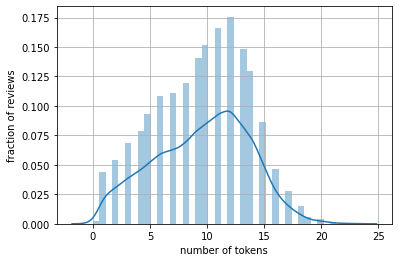

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

num_tokens = [len(tokens) for tokens in sequences]
num_tokens = np.array(num_tokens)
sn.distplot( num_tokens )
plt.grid(True)

mean_num_tokens = num_tokens.mean()
std_num_tokens = num_tokens.std()
print("mean nmber of tokens: {}".format(mean_num_tokens))
print("std of tokens: {}".format(std_num_tokens))
plt.xlabel('number of tokens')
plt.ylabel('fraction of reviews')

In [ ]:
# Max input length (max number of words) 
# max_seq_len = 500

max_seq_len = int(mean_num_tokens + 2.5 * std_num_tokens)
print("max length taken: {}".format(max_seq_len))
print("untrimmed: {}".format(np.sum(num_tokens < max_seq_len) / len(num_tokens)))

max length taken: 19
untrimmed: 0.9930327868852459


In [ ]:
#padding

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,  226,  185,  991],
       [   0,    0,    0, ...,  266,   42,   42],
       [   0,    0,    0, ..., 1118,  149, 7984],
       ...,
       [   0,    0,    0, ...,  491,  123,  315],
       [   0,    0,    0, ...,   93, 1122, 4493],
       [   0,    0,    0, ...,  105,  126,  171]], dtype=int32)

In [ ]:
print(sequence_test[0])
print(X_test_pad[0])

[743, 459, 3032, 2911, 63, 1270, 155, 446, 4290]
[   0    0    0    0    0    0    0    0    0    0  743  459 3032 2911
   63 1270  155  446 4290]


In [ ]:
X_train_pad[10160]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,   63, 3496,
       4389, 4390,  874, 2943, 3497,   16,  391, 2564], dtype=int32)

In [ ]:
X_test_pad.shape

(2928, 19)

In [ ]:
X_test_pad

array([[    0,     0,     0, ...,   155,   446,  4290],
       [    0,     0,     0, ...,     3,  7007,     5],
       [    0,     0,     0, ...,   140,  1265,   167],
       ...,
       [    0,     0,     0, ...,     4,     3, 13978],
       [    0,     0,     0, ...,   496,   882,   495],
       [    0,     0,     0, ...,  2365,  6675,   191]], dtype=int32)

In [ ]:
X_train_pad_df = pd.DataFrame(X_train_pad)
X_train_pad_df.to_csv('X_train_pad.csv', index=False, header=False)

X_test_pad_df = pd.DataFrame(X_test_pad)
X_test_pad_df.to_csv('X_test_pad.csv', index=False, header=False)

###Pretrained Word Embedding

In [ ]:
import urllib.request
import zipfile
import os

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(15340, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 10092
New words found: 5247


In [ ]:
# Embedding layer before the actaul LSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

###Modelling

In [ ]:
batch_size = 32
epochs = 200

In [ ]:
#model
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import *

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc_manual = ModelCheckpoint('best_manual.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1) 
mc_vader = ModelCheckpoint('best_vader.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1) 
mc_afinn = ModelCheckpoint('best_afinn.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1) 
mc_swn = ModelCheckpoint('best_swn.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1) 
mc_liu = ModelCheckpoint('best_liu.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1) 

model = Sequential()
model.add(embedd_layer)
model.add(LSTM(8, return_sequences=True, dropout=0.5))
model.add(LSTM(8, return_sequences=True, dropout=0.5))
model.add(LSTM(8, return_sequences=True, dropout=0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 300)           4602000   
                                                                 
 lstm_3 (LSTM)               (None, 19, 8)             9888      
                                                                 
 lstm_4 (LSTM)               (None, 19, 8)             544       
                                                                 
 lstm_5 (LSTM)               (None, 19, 8)             544       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                      

In [ ]:
# #model
# from tensorflow.keras.layers import GlobalMaxPooling1D
# from tensorflow.keras.optimizers import Adam
# from keras.callbacks import *

# batch_size = 32
# epochs = 50

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# mc=ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1) 

# model=Sequential()

# #lstm layer
# model.add(embedd_layer)

# model.add(LSTM(8,return_sequences=True,dropout=0.3))

# #Global Maxpooling
# model.add(GlobalMaxPooling1D())

# #Dense Layer
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# model.summary()

In [ ]:
model_manual = model
model_vader = model
model_afinn = model
model_swn = model
model_liu = model

In [ ]:
hist_manual = model_manual.fit(X_train_pad, y_train_manual, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 callbacks=[mc_manual]
                )

Epoch 1/200
329/330 [============================>.] - ETA: 0s - loss: 0.8964 - accuracy: 0.6233
Epoch 1: val_accuracy improved from -inf to 0.65273, saving model to best_manual.h5
330/330 [==============================] - 20s 35ms/step - loss: 0.8965 - accuracy: 0.6233 - val_loss: 0.7605 - val_accuracy: 0.6527
Epoch 2/200
329/330 [============================>.] - ETA: 0s - loss: 0.7726 - accuracy: 0.6651
Epoch 2: val_accuracy improved from 0.65273 to 0.68942, saving model to best_manual.h5
330/330 [==============================] - 10s 31ms/step - loss: 0.7724 - accuracy: 0.6651 - val_loss: 0.7037 - val_accuracy: 0.6894
Epoch 3/200
330/330 [==============================] - ETA: 0s - loss: 0.7255 - accuracy: 0.7009
Epoch 3: val_accuracy improved from 0.68942 to 0.74061, saving model to best_manual.h5
330/330 [==============================] - 10s 31ms/step - loss: 0.7255 - accuracy: 0.7009 - val_loss: 0.6652 - val_accuracy: 0.7406
Epoch 4/200
329/330 [============================>.]

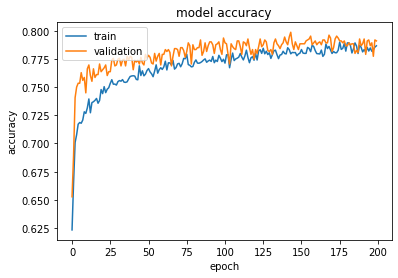

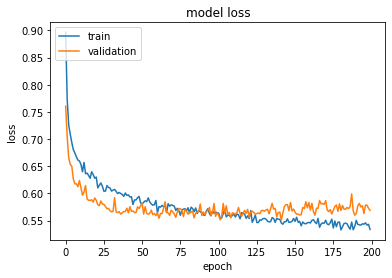

In [ ]:
#  "Accuracy"
plt.plot(hist_manual.history['accuracy'])
plt.plot(hist_manual.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_manual.history['loss'])
plt.plot(hist_manual.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_manual = model_manual.predict(X_test_pad)
predictions_manual = np.argmax(predictions_manual, axis=1)
predictions_manual = [class_names[pred] for pred in predictions_manual]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_manual) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_manual, average='micro') * 100))

92/92 [==============================] - 2s 8ms/step
Accuracy: 80.40%

F1 Score: 80.40


In [ ]:
hist_vader = model_vader.fit(X_train_pad, y_train_vader, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 callbacks=[mc_vader])

Epoch 1/200
330/330 [==============================] - ETA: 0s - loss: 0.9343 - accuracy: 0.5726
Epoch 1: val_accuracy improved from -inf to 0.64249, saving model to best_vader.h5
330/330 [==============================] - 11s 32ms/step - loss: 0.9343 - accuracy: 0.5726 - val_loss: 0.8094 - val_accuracy: 0.6425
Epoch 2/200
329/330 [============================>.] - ETA: 0s - loss: 0.8693 - accuracy: 0.6023
Epoch 2: val_accuracy improved from 0.64249 to 0.66980, saving model to best_vader.h5
330/330 [==============================] - 17s 51ms/step - loss: 0.8696 - accuracy: 0.6020 - val_loss: 0.7763 - val_accuracy: 0.6698
Epoch 3/200
329/330 [============================>.] - ETA: 0s - loss: 0.8338 - accuracy: 0.6182
Epoch 3: val_accuracy improved from 0.66980 to 0.70137, saving model to best_vader.h5
330/330 [==============================] - 11s 33ms/step - loss: 0.8342 - accuracy: 0.6179 - val_loss: 0.7453 - val_accuracy: 0.7014
Epoch 4/200
329/330 [============================>.] - 

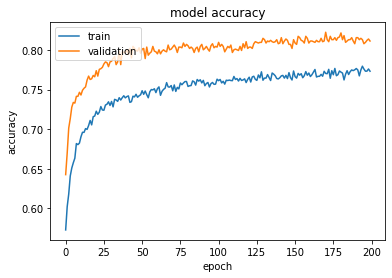

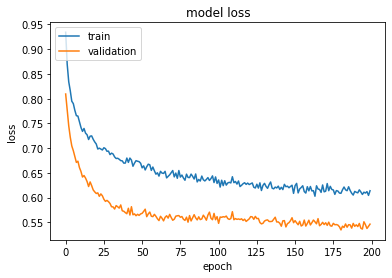

In [ ]:
#  "Accuracy"
plt.plot(hist_vader.history['accuracy'])
plt.plot(hist_vader.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_vader.history['loss'])
plt.plot(hist_vader.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_vader = model_vader.predict(X_test_pad)
predictions_vader = np.argmax(predictions_vader, axis=1)
predictions_vader = [class_names[pred] for pred in predictions_vader]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_vader) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_vader, average='micro') * 100))

92/92 [==============================] - 1s 7ms/step
Accuracy: 54.27%

F1 Score: 54.27


In [ ]:
hist_afinn = model_afinn.fit(X_train_pad, y_train_afinn, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 callbacks=[mc_afinn])

Epoch 1/200
329/330 [============================>.] - ETA: 0s - loss: 0.7183 - accuracy: 0.7280
Epoch 1: val_accuracy improved from -inf to 0.80119, saving model to best_afinn.h5
330/330 [==============================] - 11s 32ms/step - loss: 0.7183 - accuracy: 0.7280 - val_loss: 0.5555 - val_accuracy: 0.8012
Epoch 2/200
329/330 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.7367
Epoch 2: val_accuracy did not improve from 0.80119
330/330 [==============================] - 10s 31ms/step - loss: 0.6890 - accuracy: 0.7367 - val_loss: 0.5491 - val_accuracy: 0.8003
Epoch 3/200
330/330 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7374
Epoch 3: val_accuracy did not improve from 0.80119
330/330 [==============================] - 10s 31ms/step - loss: 0.6812 - accuracy: 0.7374 - val_loss: 0.5399 - val_accuracy: 0.8003
Epoch 4/200
329/330 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.7396
Epoch 4: val_accuracy did no

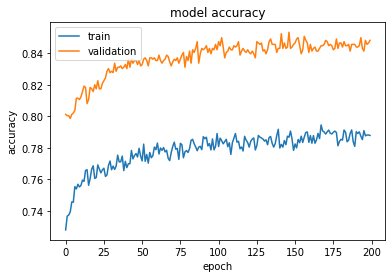

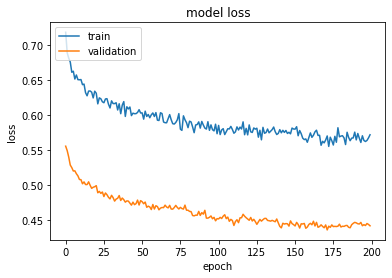

In [ ]:
#  "Accuracy"
plt.plot(hist_afinn.history['accuracy'])
plt.plot(hist_afinn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_afinn.history['loss'])
plt.plot(hist_afinn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_afinn = model_afinn.predict(X_test_pad)
predictions_afinn = np.argmax(predictions_afinn, axis=1)
predictions_afinn = [class_names[pred] for pred in predictions_afinn]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_afinn) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_afinn, average='micro') * 100))

92/92 [==============================] - 1s 8ms/step
Accuracy: 55.50%

F1 Score: 55.50


In [ ]:
hist_swn = model_swn.fit(X_train_pad, y_train_swn, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 callbacks=[mc_swn])

Epoch 1/200
329/330 [============================>.] - ETA: 0s - loss: 1.0795 - accuracy: 0.4774
Epoch 1: val_accuracy improved from -inf to 0.52730, saving model to best_swn.h5
330/330 [==============================] - 10s 32ms/step - loss: 1.0795 - accuracy: 0.4774 - val_loss: 0.9802 - val_accuracy: 0.5273
Epoch 2/200
329/330 [============================>.] - ETA: 0s - loss: 1.0210 - accuracy: 0.4973
Epoch 2: val_accuracy improved from 0.52730 to 0.53328, saving model to best_swn.h5
330/330 [==============================] - 11s 33ms/step - loss: 1.0209 - accuracy: 0.4975 - val_loss: 0.9725 - val_accuracy: 0.5333
Epoch 3/200
329/330 [============================>.] - ETA: 0s - loss: 1.0129 - accuracy: 0.5056
Epoch 3: val_accuracy improved from 0.53328 to 0.53413, saving model to best_swn.h5
330/330 [==============================] - 11s 33ms/step - loss: 1.0132 - accuracy: 0.5053 - val_loss: 0.9697 - val_accuracy: 0.5341
Epoch 4/200
329/330 [============================>.] - ETA: 0

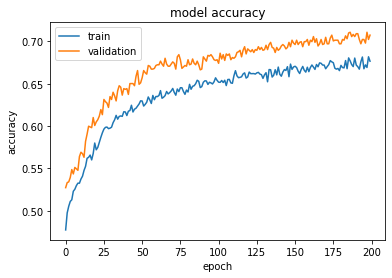

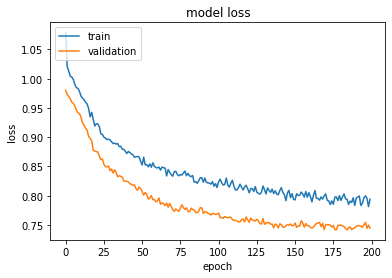

In [ ]:
#  "Accuracy"
plt.plot(hist_swn.history['accuracy'])
plt.plot(hist_swn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_swn.history['loss'])
plt.plot(hist_swn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_swn = model_swn.predict(X_test_pad)
predictions_swn = np.argmax(predictions_swn, axis=1)
predictions_swn = [class_names[pred] for pred in predictions_swn]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_swn) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_swn, average='micro') * 100))

92/92 [==============================] - 1s 8ms/step
Accuracy: 49.01%

F1 Score: 49.01


In [ ]:
hist_liu = model_liu.fit(X_train_pad, y_train_liu, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.1,
                 callbacks=[mc_liu])

Epoch 1/200
330/330 [==============================] - ETA: 0s - loss: 1.0406 - accuracy: 0.4898
Epoch 1: val_accuracy improved from -inf to 0.48549, saving model to best_liu.h5
330/330 [==============================] - 20s 39ms/step - loss: 1.0406 - accuracy: 0.4898 - val_loss: 0.9956 - val_accuracy: 0.4855
Epoch 2/200
329/330 [============================>.] - ETA: 0s - loss: 0.9624 - accuracy: 0.5372
Epoch 2: val_accuracy improved from 0.48549 to 0.62116, saving model to best_liu.h5
330/330 [==============================] - 11s 33ms/step - loss: 0.9621 - accuracy: 0.5374 - val_loss: 0.8776 - val_accuracy: 0.6212
Epoch 3/200
329/330 [============================>.] - ETA: 0s - loss: 0.8826 - accuracy: 0.5970
Epoch 3: val_accuracy improved from 0.62116 to 0.66297, saving model to best_liu.h5
330/330 [==============================] - 11s 33ms/step - loss: 0.8826 - accuracy: 0.5970 - val_loss: 0.7592 - val_accuracy: 0.6630
Epoch 4/200
329/330 [============================>.] - ETA: 0

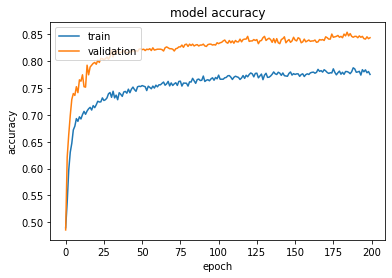

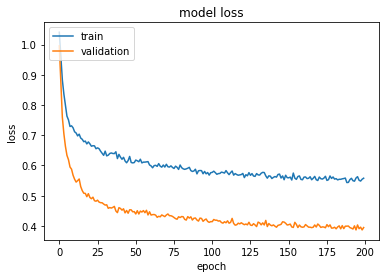

In [ ]:
#  "Accuracy"
plt.plot(hist_liu.history['accuracy'])
plt.plot(hist_liu.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_liu.history['loss'])
plt.plot(hist_liu.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_liu = model_liu.predict(X_test_pad)
predictions_liu = np.argmax(predictions_liu, axis=1)
predictions_liu = [class_names[pred] for pred in predictions_liu]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_liu) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_liu, average='micro') * 100))

92/92 [==============================] - 2s 8ms/step
Accuracy: 25.75%

F1 Score: 25.75


###Final

In [ ]:
#loading best model
from keras.models import load_model
model_manual = load_model('/content/best_manual.h5')
model_vader = load_model('/content/best_vader.h5')
model_afinn = load_model('/content/best_afinn.h5')
model_swn = load_model('/content/best_swn.h5')
model_liu = load_model('/content/best_liu.h5')

In [ ]:
y_prob_manual = model_manual.predict(X_test_pad) 
y_classes_manual = y_prob_manual.argmax(axis=-1)

y_prob_vader = model_vader.predict(X_test_pad) 
y_classes_vader = y_prob_vader.argmax(axis=-1)

y_prob_afinn = model_afinn.predict(X_test_pad) 
y_classes_afinn = y_prob_afinn.argmax(axis=-1)

y_prob_swn = model_swn.predict(X_test_pad) 
y_classes_swn = y_prob_swn.argmax(axis=-1)

y_prob_liu = model_liu.predict(X_test_pad) 
y_classes_liu = y_prob_liu.argmax(axis=-1)

92/92 [==============================] - 4s 12ms/step


In [ ]:
def convert_to_label(list_name):
  result = []
  for index_num in range(0,len(list_name)):
    if list_name[index_num]==0:
      result.append('negative')
    elif list_name[index_num]==1:
      result.append('neutral')
    elif list_name[index_num]==2:
      result.append('positive')
  return result

In [ ]:
label_result_manual = convert_to_label(y_classes_manual)
label_result_vader = convert_to_label(y_classes_vader)
label_result_afinn = convert_to_label(y_classes_afinn)
label_result_swn = convert_to_label(y_classes_swn)
label_result_liu = convert_to_label(y_classes_liu)

In [ ]:
test_df['model_manual_label'] = convert_to_label(y_classes_manual)
test_df['model_vader_label'] = convert_to_label(y_classes_vader)
test_df['model_afinn_label'] = convert_to_label(y_classes_afinn)
test_df['model_swn_label'] = convert_to_label(y_classes_swn)
test_df['model_liu_label'] = convert_to_label(y_classes_liu)

In [ ]:
test_df.head()

,text,label,vader_label,afinn_label,swn_label,liu_label,model_manual_label,model_vader_label,model_afinn_label,model_swn_label,model_liu_label
13288,complete lack faith companies really shame thi...,negative,negative,negative,negative,positive,negative,negative,negative,positive,positive
1054,8602947 jon http tco 58tutgli0d thanks,neutral,positive,positive,positive,neutral,positive,positive,positive,positive,neutral
8500,waiting flt 105 chicago hasnt aircraft left bu...,negative,neutral,neutral,positive,neutral,negative,neutral,neutral,positive,neutral
6595,thank,neutral,positive,positive,neutral,negative,positive,positive,positive,neutral,negative
3937,sfogt bos nonstop flights competitively priced...,negative,neutral,neutral,negative,neutral,neutral,neutral,neutral,neutral,negative


In [ ]:
test_df.to_csv('test_df_with_label.csv', index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy Manual: {:.2f}'.format(accuracy_score(test_df['label'], test_df['model_manual_label'])))
print('Accuracy VADER: {:.2f}'.format(accuracy_score(test_df['label'], test_df['model_vader_label'])))
print('Accuracy Afinn: {:.2f}'.format(accuracy_score(test_df['label'], test_df['model_afinn_label'])))
print('Accuracy SWN: {:.2f}'.format(accuracy_score(test_df['label'], test_df['model_swn_label'])))
print('Accuracy Liu: {:.2f}'.format(accuracy_score(test_df['label'], test_df['model_liu_label'])))

Accuracy Manual: 0.80
Accuracy VADER: 0.54
Accuracy Afinn: 0.55
Accuracy SWN: 0.47
Accuracy Liu: 0.25


In [ ]:
model_manual.predict()

AttributeError: ignored

In [ ]:
y_classes_manual[0]

2

######Model Testing and Evaluate

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

92/92 [==============================] - 1s 7ms/step
Accuracy: 25.75%

F1 Score: 25.75


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 300)           4602000   
                                                                 
 lstm (LSTM)                 (None, 19, 8)             9888      
                                                                 
 lstm_1 (LSTM)               (None, 19, 8)             544       
                                                                 
 lstm_2 (LSTM)               (None, 19, 8)             544       
                                                                 
 global_max_pooling1d (Globa  (None, 8)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                144       
                                                        

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 25.75


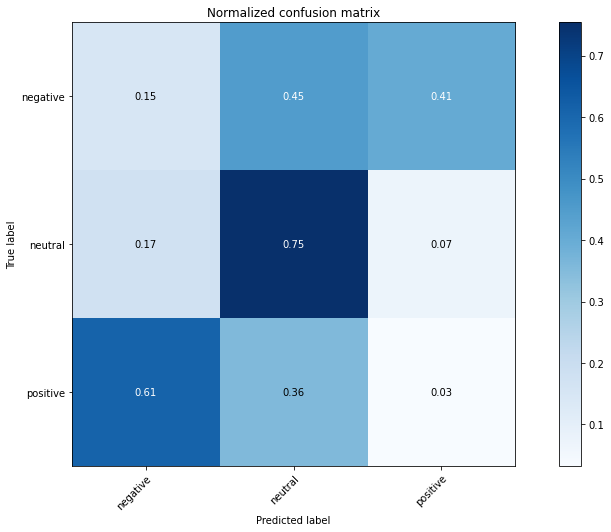

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(test_df.label, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

##5. Embedding & Modeling - Err

####Preprocessing

In [ ]:
#2nd method preprocessing

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

data['text'] = data['text'].apply(clean_text)
data.head()

,text,sentiment values,splitset_label,label,vader_score,vader_label,textblob_score,textblob_label,afinn_score,afinn_label,swn_score,swn_label,liu_score,liu_label
0,rock destined 21st century new conan going mak...,0.69444,1,positive,0.3612,positive,0.212121,positive,3.0,positive,0.875,positive,0,neutral
1,gorgeously elaborate continuation lord rings t...,0.83333,1,positive,0.8069,positive,0.244444,positive,2.0,positive,0.625,positive,-1,negative
2,effective tootepid biopic,0.51389,2,neutral,0.2617,positive,0.600000,positive,2.0,positive,0.125,positive,0,neutral
3,sometimes like go movies fun wasabi good place...,0.73611,2,positive,0.8271,positive,0.500000,positive,9.0,positive,1.125,positive,-3,negative
4,emerges something rare issue movie honest keen...,0.86111,2,positive,0.6592,positive,0.450000,positive,4.0,positive,1.000,positive,-2,negative


In [ ]:
data.to_csv('labelled-preprocessed.csv', index=False)

####Select and Split Data

In [ ]:
data_clean = data[['text','label','vader_label','textblob_label','afinn_label','swn_label','liu_label', 'splitset_label']].copy()

In [ ]:
data_clean.head()

,text,label,vader_label,textblob_label,afinn_label,swn_label,liu_label,splitset_label
0,rock destined 21st century new conan going mak...,positive,positive,positive,positive,positive,neutral,1
1,gorgeously elaborate continuation lord rings t...,positive,positive,positive,positive,positive,negative,1
2,effective tootepid biopic,neutral,positive,positive,positive,positive,neutral,2
3,sometimes like go movies fun wasabi good place...,positive,positive,positive,positive,positive,negative,2
4,emerges something rare issue movie honest keen...,positive,positive,positive,positive,positive,negative,2


In [ ]:
#data splitp
train_df = data_clean.loc[data_clean['splitset_label'] == 1]
test_df = data_clean.loc[data_clean['splitset_label'] == 2]

In [ ]:
train_df.head()

,text,label,vader_label,textblob_label,afinn_label,swn_label,liu_label,splitset_label
0,rock destined 21st century new conan going mak...,positive,positive,positive,positive,positive,neutral,1
1,gorgeously elaborate continuation lord rings t...,positive,positive,positive,positive,positive,negative,1
60,singer composer bryan adams contributes slew s...,positive,positive,neutral,positive,negative,positive,1
61,think america would enough plucky british ecce...,neutral,positive,neutral,positive,negative,negative,1
62,yet act still charming,positive,positive,positive,positive,negative,negative,1


In [ ]:
test_df.head()

,text,label,vader_label,textblob_label,afinn_label,swn_label,liu_label,splitset_label
2,effective tootepid biopic,neutral,positive,positive,positive,positive,neutral,2
3,sometimes like go movies fun wasabi good place...,positive,positive,positive,positive,positive,negative,2
4,emerges something rare issue movie honest keen...,positive,positive,positive,positive,positive,negative,2
5,film provides great insight neurotic mindset c...,neutral,positive,positive,positive,positive,negative,2
6,offers rare combination entertainment education,positive,positive,positive,neutral,positive,neutral,2


In [ ]:
test_df.shape

(2210, 8)

###.

####Label Encoding

In [ ]:
# Number of labels: positive, negative, neutral
num_classes = 3

# Number of dimensions for word embedding
embed_num_dims = 300

#category
class_names = ['negative', 'neutral', 'positive']

In [ ]:
#text split
X_train = train_df.text
X_test = test_df.text

#label split
y_train_manual = train_df.label
y_test_manual = test_df.label

y_train_vader = train_df.vader_label
y_test_vader = test_df.vader_label

y_train_textblob = train_df.textblob_label
y_test_textblob = test_df.textblob_label

y_train_afinn = train_df.afinn_label
y_test_afinn = test_df.afinn_label

y_train_swn = train_df.swn_label
y_test_swn = test_df.swn_label

y_train_liu = train_df.liu_label
y_test_liu = test_df.liu_label

In [ ]:
encoding = {
    'negative': 1,
    'neutral': 2,
    'positive': 3
}

# Integer labels
y_train_manual = [encoding[x] for x in train_df.label]
y_test_manual = [encoding[x] for x in test_df.label]

y_train_vader = [encoding[x] for x in train_df.vader_label]
y_test_vader = [encoding[x] for x in test_df.vader_label]

y_train_textblob = [encoding[x] for x in train_df.textblob_label]
y_test_textblob = [encoding[x] for x in test_df.textblob_label]

y_train_afinn = [encoding[x] for x in train_df.afinn_label]
y_test_afinn = [encoding[x] for x in test_df.afinn_label]

y_train_swn = [encoding[x] for x in train_df.swn_label]
y_test_swn = [encoding[x] for x in test_df.swn_label]

y_train_liu = [encoding[x] for x in train_df.liu_label]
y_test_liu = [encoding[x] for x in test_df.liu_label]

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_manual = to_categorical(y_train_manual)
y_test_manual = to_categorical(y_test_manual)

y_train_vader = to_categorical(y_train_vader)
y_test_vader = to_categorical(y_test_vader)

y_train_textblob = to_categorical(y_train_textblob)
y_test_textblob = to_categorical(y_test_textblob)

y_train_afinn = to_categorical(y_train_afinn)
y_test_afinn = to_categorical(y_test_afinn)

y_train_swn = to_categorical(y_train_swn)
y_test_swn = to_categorical(y_test_swn)

y_train_liu = to_categorical(y_train_liu)
y_test_liu = to_categorical(y_test_liu)

y_train_manual

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

####Tokenizing

In [ ]:
texts = data_clean.text.tolist()

texts_train = X_train.tolist()
texts_test = X_test.tolist()

In [ ]:
#tokenization + fitting

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)

sequences = tokenizer.texts_to_sequences(data.text)
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(tokenizer.word_counts)+1

print('Number of unique words: {}'.format(vocab_size))

Number of unique words: 19183


####Padding

mean nmber of tokens: 9.41830451286377
std of tokens: 4.734384110704758


Text(0, 0.5, 'fraction of reviews')

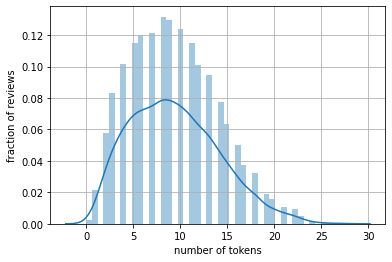

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

num_tokens = [len(tokens) for tokens in sequences]
num_tokens = np.array(num_tokens)
sn.distplot( num_tokens )
plt.grid(True)

mean_num_tokens = num_tokens.mean()
std_num_tokens = num_tokens.std()
print("mean nmber of tokens: {}".format(mean_num_tokens))
print("std of tokens: {}".format(std_num_tokens))
plt.xlabel('number of tokens')
plt.ylabel('fraction of reviews')

In [ ]:
# Max input length (max number of words) 
# max_seq_len = 500

max_seq_len = int(mean_num_tokens + 2.5 * std_num_tokens)
print("max length taken: {}".format(max_seq_len))
print("untrimmed: {}".format(np.sum(num_tokens < max_seq_len) / len(num_tokens)))

max length taken: 21
untrimmed: 0.9821172501054407


In [ ]:
#padding

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ..., 6898,  750, 9880],
       [   0, 3109, 1935, ..., 9881, 5300, 9882],
       [   0, 4365, 6925, ..., 5320,  342,  148],
       ...,
       [   0,    0,    0, ...,   20,  360,  292],
       [   0,    0,    0, ...,  265, 1964, 3439],
       [   0,    0,    0, ...,    0,  401, 5209]], dtype=int32)

In [ ]:
X_test_pad.shape

(2210, 21)

####Pretrained Word Embedding

In [ ]:
import urllib.request
import zipfile
import os

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(19183, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 16185
New words found: 2997


In [ ]:
# Embedding layer before the actaul LSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

####Modelling

In [ ]:
#model
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
batch_size = 36
epochs = 200

model = Sequential()
model.add(embedd_layer)
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 300)           5754900   
                                                                 
 lstm_12 (LSTM)              (None, 21, 64)            93440     
                                                                 
 dropout_4 (Dropout)         (None, 21, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 21, 64)            33024     
                                                                 
 lstm_14 (LSTM)              (None, 21, 64)            33024     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                      

In [ ]:
model_manual = model
model_vader = model
model_textblob = model
model_afinn = model
model_swn = model
model_liu = model

In [ ]:
hist_manual = model_manual.fit(X_train_pad, y_train_manual, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_manual))

Epoch 1/10


ValueError: ignored

In [ ]:
#  "Accuracy"
plt.plot(hist_manual.history['accuracy'])
plt.plot(hist_manual.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_manual.history['loss'])
plt.plot(hist_manual.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_manual = model_manual.predict(X_test_pad)
predictions_manual = np.argmax(predictions_manual, axis=1)
predictions_manual = [class_names[pred] for pred in predictions_manual]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_manual) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_manual, average='micro') * 100))

In [ ]:
hist_vader = model_vader.fit(X_train_pad, y_train_vader, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_vader))

In [ ]:
#  "Accuracy"
plt.plot(hist_vader.history['accuracy'])
plt.plot(hist_vader.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_vader.history['loss'])
plt.plot(hist_vader.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_vader = model_vader.predict(X_test_pad)
predictions_vader = np.argmax(predictions_vader, axis=1)
predictions_vader = [class_names[pred] for pred in predictions_vader]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_vader) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_vader, average='micro') * 100))

In [ ]:
hist_afinn = model_afinn.fit(X_train_pad, y_train_afinn, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_afinn))

In [ ]:
#  "Accuracy"
plt.plot(hist_afinn.history['accuracy'])
plt.plot(hist_afinn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_afinn.history['loss'])
plt.plot(hist_afinn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_afinn = model_afinn.predict(X_test_pad)
predictions_afinn = np.argmax(predictions_afinn, axis=1)
predictions_afinn = [class_names[pred] for pred in predictions_afinn]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_afinn) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_afinn, average='micro') * 100))

In [ ]:
hist_swn = model_swn.fit(X_train_pad, y_train_swn, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_swn))

In [ ]:
#  "Accuracy"
plt.plot(hist_swn.history['accuracy'])
plt.plot(hist_swn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_swn.history['loss'])
plt.plot(hist_swn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions_swn = model_swn.predict(X_test_pad)
predictions_swn = np.argmax(predictions_swn, axis=1)
predictions_swn = [class_names[pred] for pred in predictions_swn]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_swn) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_swn, average='micro') * 100))

In [ ]:
hist_liu = model_liu.fit(X_train_pad, y_train_liu, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_liu))

In [ ]:
predictions_liu = model_liu.predict(X_test_pad)
predictions_liu = np.argmax(predictions_liu, axis=1)
predictions_liu = [class_names[pred] for pred in predictions_liu]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions_liu) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions_liu, average='micro') * 100))

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

######Model Testing and Evaluate

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

In [ ]:
model.summary()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(test_df.label, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#Another Model


###Data Augmentation

In [ ]:
data_aug = data[data['label'] == 'neutral']
data_aug['text'] = data_aug['text'].apply(lambda x : eda_aug.augment(x))

from random import randrange
for row in data_aug.index:
  try:
    num = randrange(0,2)
    data_aug['text'][row] = data_aug['text'][row][num]
  except:
    data_aug['text'][row] = data_aug['text'][row][0]

In [ ]:
data = data.append(data_aug)

In [ ]:
data = data.reset_index()

In [ ]:
data.head()

,index,text,sentiment values,splitset_label,label
0,0,The Rock is destined to be the 21st Century 's...,0.69444,1,positive
1,1,The gorgeously elaborate continuation of `` Th...,0.83333,1,positive
2,2,Effective but too-tepid biopic,0.51389,2,neutral
3,3,If you sometimes like to go to the movies to h...,0.73611,2,positive
4,4,"Emerges as something rare , an issue movie tha...",0.86111,2,positive


In [ ]:
#model
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
batch_size = 32
epochs = 50

model=Sequential()

#lstm layer
model.add(embedd_layer)

model.add(LSTM(8,return_sequences=True,dropout=0.3))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 300)           5754900   
                                                                 
 lstm_6 (LSTM)               (None, 21, 8)             9888      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                      

### TextBlob

####Create Sentiment Score Function

In [ ]:
def textblob_score(sentence):
    sntmnt = textblob.TextBlob(sentence).sentiment.polarity
    return sntmnt

def textblob_label(score):
    if (score >= 0.1):
        return 'positive'
    elif ((score > -0.1) & (score < 0.1)):
        return 'neutral'
    elif (score <= -0.1):
        return 'negative'

####Calculate Sentiment Score & Create Label

In [ ]:
# start = time.time()

# textblob_score =  []

# for comment in data.text.to_list():
#     snts_score = calculate_sentiment_scores_textblob(comment)
#     textblob_score.append(snts_score)


data['textblob_score'] = data.text.apply(textblob_score)
data['textblob_label'] = data.textblob_score.apply(textblob_label)

# end = time.time()

# # total time taken
# print(f"Runtime of the program is {(end - start)/60} minutes or {(end - start)} seconds")

In [ ]:
data.head()

,text,sentiment values,splitset_label,label,vader_score,vader_label,textblob_score,textblob_label
0,The Rock is destined to be the 21st Century 's...,0.69444,1,positive,0.3612,positive,0.212121,positive
2,Effective but too-tepid biopic,0.51389,2,neutral,0.2617,positive,0.600000,positive
3,If you sometimes like to go to the movies to h...,0.73611,2,positive,0.8271,positive,0.500000,positive
5,The film provides some great insight into the ...,0.59722,2,neutral,0.5994,positive,0.275000,positive
7,Perhaps no picture ever made has more literall...,0.69444,2,positive,-0.5994,negative,0.600000,positive


In [ ]:
data['textblob_score'].min()

-1.0

#####Model 1

In [ ]:
#model
batch_size = 128
epochs = 10

model = Sequential()
model.add(embedd_layer)
model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model_history = model.fit(X_train_pad, y_train_manual,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_test_pad,y_test_manual))

In [ ]:
#  "Accuracy"
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

######Model Testing and Evaluate

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(test_df.label, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#####Model 2

In [ ]:
# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
batch_size = 128
epochs = 10

hist = model.fit(X_train_pad, y_train_manual, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_manual))

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

######Model Testing and Evaluate

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(test_df.label, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#####Model 3

In [ ]:
#model
batch_size = 128
epochs = 10

model = Sequential()
model.add(embedd_layer)
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
batch_size = 128
epochs = 10

hist = model.fit(X_train_pad, y_train_manual, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test_manual))

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

######Model Testing and Evaluate

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

print("Accuracy: {:.2f}%".format(accuracy_score(test_df.label, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(test_df.label, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(test_df.label, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#Another Model


##6. Modelling

In [ ]:
#embedding
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_text_length, trainable=False))
model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=64,epochs=10,validation_split=0.1,verbose=1)

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

In [ ]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

In [ ]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [ ]:
def preprocess(text):
    review = casefolding(text)
    review = filtering(review)
    review = tokenize(review)
    review = stopword_removal(review)
    review = stemming(review)
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

In [ ]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<0.4:
        print("Negative")
    elif score>0.4 and score<0.6:
        print("Neutral")
    else:
        print("Positive")
    print(score)

In [ ]:
prediction("this disturbing")

In [ ]:
kalimat = "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side";
prediction(kalimat)

In [ ]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

In [ ]:
y_pred=np.where(scores>0.5,1,0)

In [ ]:
y_pred

In [ ]:
cm=confusion_matrix(y_pred,y_test)
print(cm)

In [ ]:
print(accuracy_score(y_pred,y_test))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
joblib.dump(w2v_model,'word2vec.pkl')
joblib.dump(tokenizer,'tokenizer.pkl')
joblib.dump(model,'final_model.pkl')

##7. Evaluasi

### Accuracy, Precision, Recall, F1-Score, Confusion Matrix

In [ ]:
print('SVM Accuracy : ', accuracy_score(y_test,predictedSVM))
print('SVM Precision : ', precision_score(y_test,predictedSVM, average="binary", pos_label="negative"))
print('SVM Recall : ', recall_score(y_test,predictedSVM, average="binary", pos_label="negative"))
print('SVM f1_score : ', f1_score(y_test,predictedSVM, average="binary", pos_label="negative"))

print(f'confusion_matrix : \n {confusion_matrix(y_test,predictedSVM)}')
print('=========================================================\n')
print(classification_report(y_test,predictedSVM,zero_division=0))
plot_confusion_matrix(modelSVM, x_test, y_test)  
plt.show()

### Wordcloud

In [ ]:
#wordcloud positif
df_pos = data_clean[data_clean['vader_sentiment_labels'].str.contains("positive")]
wordcloud_positif = WordCloud().generate(' '.join(df_pos['text']))
plt.imshow(wordcloud_positif)
plt.axis("off")
plt.show()

In [ ]:
#wordcloud negatif
df_neg = data_clean[data_clean['vader_sentiment_labels'].str.contains("negative")]
wordcloud_negatif = WordCloud().generate(' '.join(df_neg['text']))
plt.imshow(wordcloud_negatif)
plt.axis("off")
plt.show()

### Cross Validation

In [ ]:
#Cross Validation
scores = cross_val_score(modelSVM, text_tf, data_clean['vader_sentiment_labels'], cv=10)
print('Hasil Cross Validation : ', scores)
scores_mean = np.mean(scores)
print('Rata-rata Cross Validation : ', scores_mean)

### Export and Load Model

In [ ]:
# save the model to disk
filename = 'modelSVM.sav'
pickle.dump(modelSVM, open(filename, 'wb'))
 
# load the model from disk
modelSVM_loaded = pickle.load(open(filename, 'rb'))
result = modelSVM_loaded.score(x_test, y_test)

predictSVM = modelSVM_loaded.predict(x_test)
print('SVM Accuracy : ', accuracy_score(y_test,predictSVM))

##Other

###4. Preprocessing

###Read Dataset

In [ ]:
data = pd.read_csv('labelled.csv')

In [ ]:
data.head()

###Create Preprocessing Function

In [ ]:
#casefolding
def casefolding(text):
  text = text.lower()
  return text

# #filtering
# def remove_urltag(text):
#     # Remove link web
#     text = re.sub(r'http\S+', '', text)
#     # Remove @username
#     text = re.sub('@[^\s]+', '', text)
#     # Remove #tagger
#     text = re.sub(r'#([^\s]+)', '', text)
#     # remove br tag
#     text = re.sub('<br />', '', text)
#     return text

# def remove_num(text):
#     text = re.sub(r'[0-9]', '', text)
#     return text

# def remove_punct(text):
#     text = re.sub(r'[^\w\s]', '', text)
#     return text

def filtering(text):
    # Remove link web
    text = re.sub(r'http\S+', '', text)
    # remove br tag
    text = re.sub('<br />', '', text)
    # Remove @username
    text = re.sub('@[^\s]+', '', text)
    # Remove #tagger
    text = re.sub(r'#([^\s]+)', '', text)
    # Remove angka termasuk angka yang berada dalam string
    # Remove non ASCII chars
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    text = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r'\\u\w\w\w\w', '', text)
    # Remove simbol, angka dan karakter aneh
    text = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", text)
    return text    

#tokenizing
def tokenize(text):
    token = nltk.word_tokenize(text)
    return token

#stopword
def stopword_removal(text):
    filtering = stopwords.words('english')
    x = []
    data = []
    def myFunc(x):
      if x in filtering:
        return False
      else:
        return True
    fit = filter(myFunc, text)
    for x in fit:
      data.append(x)
    return data

#stemming
def stemming(text):
    stemmer = PorterStemmer()
    do = []
    for w in text:
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean=[]
    d_clean=" ".join(do)
    return (d_clean)

###Start Preprocessing

In [ ]:
data['text'] = data['text'].apply(casefolding)
data.head()

In [ ]:
data['text']=data['text'].apply(filtering)
data.head()

In [ ]:
data['text']=data['text'].apply(tokenize)
data.head()

In [ ]:
data['text']=data['text'].apply(stopword_removal)
data.head()

In [ ]:
data['text'] = data['text'].apply(stemming)
data.head()

###Drop Neutral, Drop Duplicate & Null, Check Null, Reset Index

In [ ]:
# data = data[(data.vader_label != "neutral")]
# data = data[(data.textblob_label != "neutral")]
# data = data[(data.afinn_label != "neutral")]
# data = data[(data.swn_label != "neutral")]
# data = data[(data.liu_label != "neutral")]

In [ ]:
# data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data = data.dropna()

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.isnull().sum()

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
tes = []

tes.append(tokenizer.word_index.get('rock'))
tes.append(tokenizer.word_index.get('destin'))
tes.append(tokenizer.word_index.get('st'))
tes.append(tokenizer.word_index.get('centuri'))
tes.append(tokenizer.word_index.get('new'))
tes.append(tokenizer.word_index.get('conan'))
tes.append(tokenizer.word_index.get('go'))
tes.append(tokenizer.word_index.get('make'))
tes.append(tokenizer.word_index.get('splash'))
tes.append(tokenizer.word_index.get('even'))
tes.append(tokenizer.word_index.get('greater'))
tes

In [ ]:
tes_seq = pad_sequences(tokenizer.texts_to_sequences('rock destin st centuri new conan go make splash even greater'), maxlen=300)
tes_seq

####Create Flair Classification Function

In [ ]:
# def make_sentences(text):
#     sentences = [sent for sent in split_single(text)]
#     return sentences

def flair_score(sentence):
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    label = text.labels[0].to_dict()['value'] 
    if label == 'POSITIVE':
        confidence = text.to_dict()['labels'][0]['confidence']
    else:
        confidence = -(text.to_dict()['labels'][0]['confidence'])
    return confidence

def flair_label(score):
    if (score > 0):
        return 'positive'
    elif (score < 0):
        return 'negative'

# def get_predict_result(sentences):
#     """ Call predict on every sentence of a text """
#     flair_confidence = []
    
#     for i in range(0, len(sentences)): 
#         flair_confidence.append(flair_predict(sentences[i]))
#     return flair_confidence

# def flair_predict_confidence(sentence):
#     text = Sentence(sentence)
#     classifier.predict(text)
#     return text.labels[0].to_dict()['confidence']

####Calculate Sentiment Score & Create Label

In [ ]:
# data['sentences'] = data.text.apply(make_sentences)
data['flair_score'] = data.text.apply(flair_score)
data['flair_label'] = data.flair_score.apply(flair_label)

In [ ]:
data.head()

####Remove Neutral Sentiment

In [ ]:
data = data[data.vader_sentiment_labels != 'neutral']

In [ ]:
data.head()

###Create w2v Model

In [ ]:
documents = [text.split() for text in train_df.text]
documents[0]

In [ ]:
import seaborn as sn
num_tokens = [len(tokens) for tokens in documents]
num_tokens = np.array(num_tokens)
sn.distplot( num_tokens )
plt.grid(True)

mean_num_tokens = num_tokens.mean()
std_num_tokens = num_tokens.std()
print("mean nmber of tokens: {}".format(mean_num_tokens))
print("std of tokens: {}".format(std_num_tokens))
plt.xlabel('number of tokens')
plt.ylabel('fraction of reviews')

In [ ]:
len_data = [len(x.split()) for x in train_df.text]
print(np.mean(len_data))
print(np.median(len_data))
print(np.std(len_data))
print(np.min(len_data))
print(np.max(len_data))
print(np.percentile(len_data, 90))

In [ ]:
unique_string = set()
for x in train_df.text:
    for y in x.split():
        unique_string.add(y)
        
print(len(unique_string))

In [ ]:
max_features = 16500 # how many unique words to use (since the total of unique word is only 2816)
maxlen = 16 # max number of words in a text to use (from 90th percentile)

start_preprocess2 = time.time()
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df.text)

list_tokenized_train = tokenizer.texts_to_sequences(train_df.text.values)
list_tokenized_test = tokenizer.texts_to_sequences(test_df.text.values)

X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

end_preprocess2 = time.time()

In [ ]:
embed_size = 100
word_index = tokenizer.word_index
nb_words = max_features
embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

In [ ]:
w2v_model.wv.most_similar("bad")

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

In [ ]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=max_text_length)
y_train=train_df.label

X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=max_text_length)
y_test=test_df.label

In [ ]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.fit_transform(y_test)

# Referensi Kode Program

https://www.youtube.com/watch?v=8ApgsLvbTz4

https://github.com/kungfumas/analisa-sentimen-support-vector-machine/blob/master/Sentiment%20Analysis%20with%20Python.ipynb